In [2]:
%reload_ext autoreload
%autoreload 2
from ripple_heterogeneity.utils import loading,functions,well_traversal_classification
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib
import nelpy as nel
import glob
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

## locate sessions with w and t maze from HMC2

In [89]:
rootdir = 'Z:/Data/HMC2/'
basepaths = glob.glob(f'{rootdir}/*/')
basepaths = [os.path.normpath(x) for x in basepaths]
epoch_df = pd.DataFrame()
for basepath in basepaths:
    epoch_df_temp = loading.load_epoch(basepath)
    epoch_df_temp["basepath"] = basepath
    epoch_df = pd.concat([epoch_df,epoch_df_temp],ignore_index=True)

df = pd.DataFrame()
df["basepath"] = epoch_df.query("environment.str.contains('wmaze|tmaze')").basepath.unique()
df

,basepath
0,Z:\Data\HMC2\day10
1,Z:\Data\HMC2\day11
2,Z:\Data\HMC2\day12
3,Z:\Data\HMC2\day6
4,Z:\Data\HMC2\day7
5,Z:\Data\HMC2\day8
6,Z:\Data\HMC2\day9


## score performance and mazes

In [105]:
def score_tmaze(
    position_df, center_well=[55, 70], y_offset=21, max_distance_from_well=10
):
    well_locations = np.array(
        [
            center_well,
            [
                center_well[0],
                center_well[1] + y_offset,
            ],
            [
                center_well[0],
                center_well[1] - y_offset,
            ],
        ]
    )
    temp_df = position_df[~np.isnan(position_df.x)]

    segments_df, _ = well_traversal_classification.segment_path(
        temp_df["timestamps"].values,
        temp_df[["x", "y"]].values,
        well_locations,
        max_distance_from_well=max_distance_from_well,
    )
    x_range = position_df.x.max() - position_df.x.min()
    segments_df = segments_df.query("distance_traveled > @x_range")
    segments_df = segments_df.query("from_well == 1.0")

    next_trial_diff = np.diff(segments_df.to_well)
    t_maze_prop_correct = sum(next_trial_diff != 0) / len(next_trial_diff)

    return t_maze_prop_correct, len(segments_df), segments_df


def score_wmaze(
    position_df, center_well=[30, 70], y_offset=60, max_distance_from_well=20
):
    well_locations = np.array(
        [
            center_well,
            [
                center_well[0],
                center_well[1] + y_offset,
            ],
            [
                center_well[0],
                center_well[1] - y_offset,
            ],
        ]
    )
    temp_df = position_df[~np.isnan(position_df.x)]

    segments_df, _ = well_traversal_classification.segment_path(
        temp_df["timestamps"].values,
        temp_df[["x", "y"]].values,
        well_locations,
        max_distance_from_well=max_distance_from_well,
    )
    x_range = position_df.x.max() - position_df.x.min()
    segments_df = well_traversal_classification.score_inbound_outbound(
        segments_df, min_distance_traveled=x_range
    )

    return (
        np.mean(segments_df.query("task == 'Outbound'").is_correct),
        np.mean(segments_df.query("task == 'Inbound'").is_correct),
        len(segments_df),
        segments_df,
    )


prop_correct = []
n_trials = []
basepaths = []
direction = []
environment = []
all_segments_df = pd.DataFrame()
for basepath in df.basepath:
    position_df = loading.load_animal_behavior(basepath)
    beh_epoch = loading.load_epoch(basepath)
    if any(beh_epoch.environment.str.contains("tmaze")):

        idx = position_df.time.between(
            beh_epoch.query("environment == 'tmaze'").startTime.values[0],
            beh_epoch.query("environment == 'tmaze'").stopTime.values[0],
        )
        t_maze_prop_correct, n_trials_, segments_df = score_tmaze(position_df[idx])
        prop_correct.append(t_maze_prop_correct)
        direction.append('outbound')
        n_trials.append(n_trials_)
        basepaths.append(basepath)
        environment.append("tmaze")
        segments_df["basepath"] = basepath
        segments_df["environment"] = "tmaze"
        all_segments_df = pd.concat([all_segments_df, segments_df], ignore_index=True)

    if any(beh_epoch.environment.str.contains("wmaze")):
        idx = position_df.time.between(
            beh_epoch.query("environment == 'wmaze'").startTime.values[0],
            beh_epoch.query("environment == 'wmaze'").stopTime.values[0],
        )
        (
            w_maze_outbound_prop_correct,
            w_maze_inbound_prop_correct,
            n_trials_,
            segments_df,
        ) = score_wmaze(position_df[idx])
        prop_correct.append(w_maze_outbound_prop_correct)
        prop_correct.append(w_maze_inbound_prop_correct)
        direction.append('outbound')
        direction.append('intbound')
        n_trials.append(n_trials_)
        n_trials.append(n_trials_)
        basepaths.append(basepath)
        basepaths.append(basepath)
        environment.append("wmaze")
        environment.append("wmaze")
        segments_df["basepath"] = basepath
        segments_df["environment"] = "wmaze"
        all_segments_df = pd.concat([all_segments_df, segments_df], ignore_index=True)

prop_df = pd.DataFrame()
prop_df["prop_correct"] = np.hstack(prop_correct)
prop_df["direction"] = np.hstack(direction)
prop_df["n_trials"] = np.hstack(n_trials)
prop_df["environment"] = np.hstack(environment)
prop_df["basepath"] = np.hstack(basepaths)


## map basepaths to exposure days

In [106]:
x_order = {
    "Z:\Data\HMC2\day6":1,
    "Z:\Data\HMC2\day7":2,
    "Z:\Data\HMC2\day8":3,
    "Z:\Data\HMC2\day9":4,
    "Z:\Data\HMC2\day10":5,
    "Z:\Data\HMC2\day11":6,
    "Z:\Data\HMC2\day12":7,
}
prop_df["exposure"] = prop_df.basepath.map(x_order)


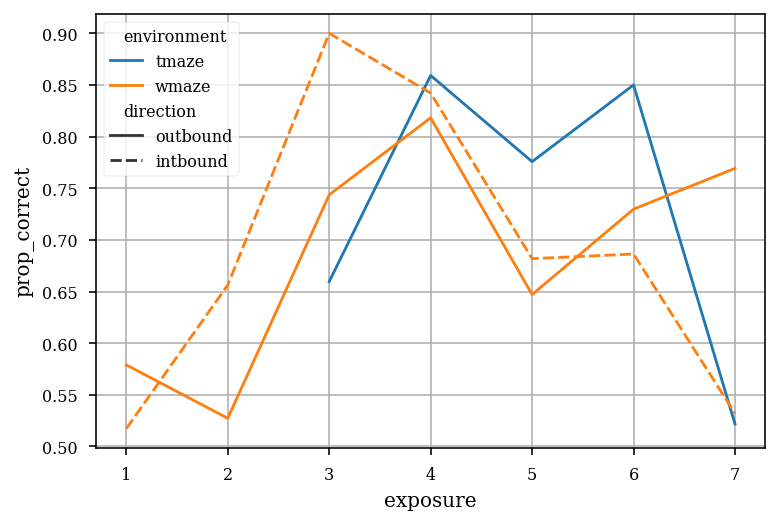

In [107]:
sns.lineplot(
    data=prop_df,
    x="exposure", y="prop_correct",
    hue="environment", style="direction",
)
plt.grid()

## save results

In [108]:
prop_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\tmaze_wmaze_performance.csv")
all_segments_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\tmaze_wmaze_all_segments_df.csv")


## testing below

In [69]:
len(segments_df)

78

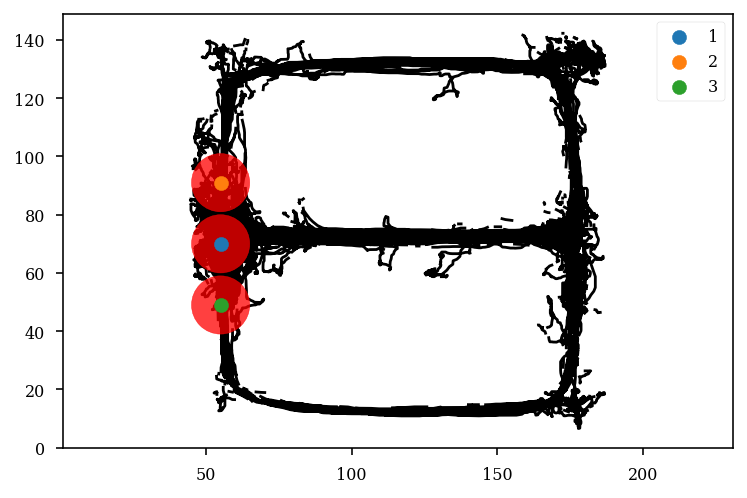

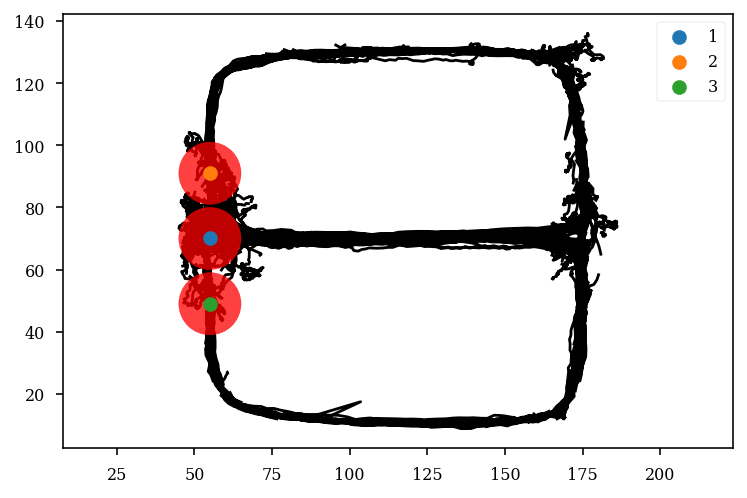

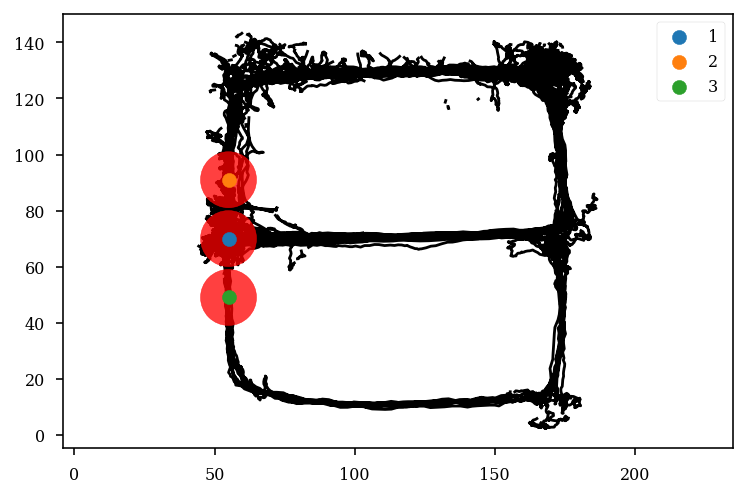

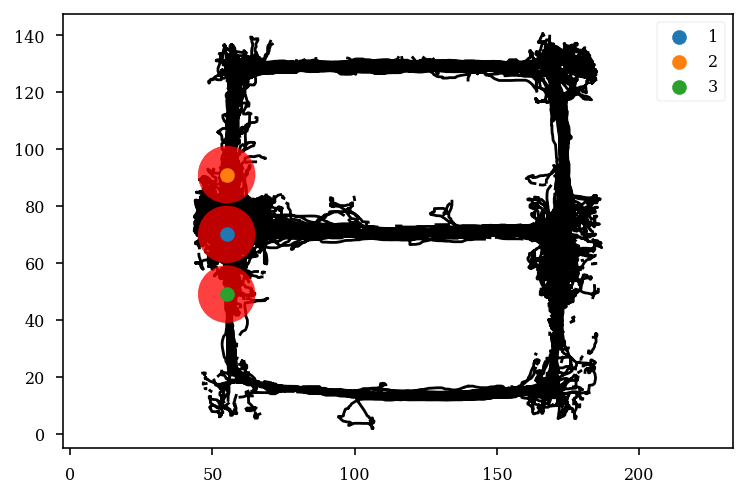

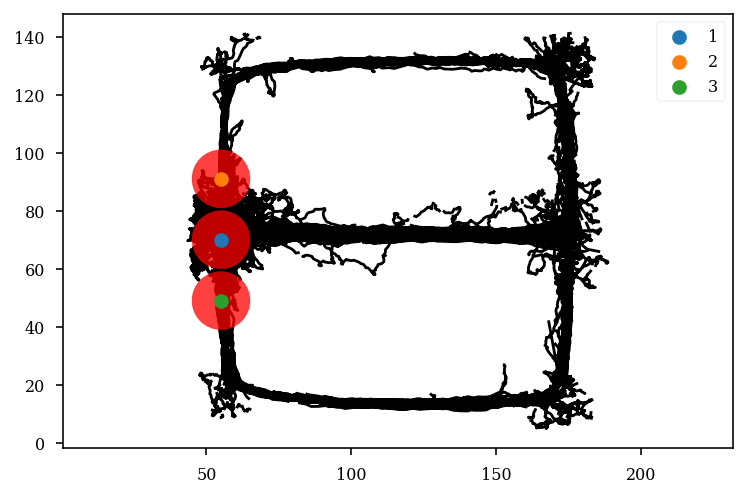

In [37]:
for basepath in basepaths.basepath:
    position_df = loading.load_animal_behavior(basepath)
    beh_epoch = loading.load_epoch(basepath)
    if (beh_epoch.environment.str.contains('tmaze') == False).all():
        continue
    idx = position_df.time.between(beh_epoch.query("environment == 'tmaze'").startTime.values[0],beh_epoch.query("environment == 'tmaze'").stopTime.values[0])
    position_df = position_df[idx]

    center_well = [55,70]
    well_locations = np.array([
        center_well,
        [
            center_well[0],
            center_well[1]+21,
        ],
        [
            center_well[0],
            center_well[1]-21,
        ]
    ])
    plt.plot(position_df.x,position_df.y,color="k")
    plt.axis("equal")
    for xy_i, xy in enumerate(well_locations):
        plt.scatter(xy[0], xy[1], s=50,label = xy_i+1,zorder=100)
        circle1 = plt.Circle((xy[0], xy[1]), 10, color='r',alpha=.75,zorder=80)
        plt.gca().add_patch(circle1)
    plt.legend()
    plt.show()

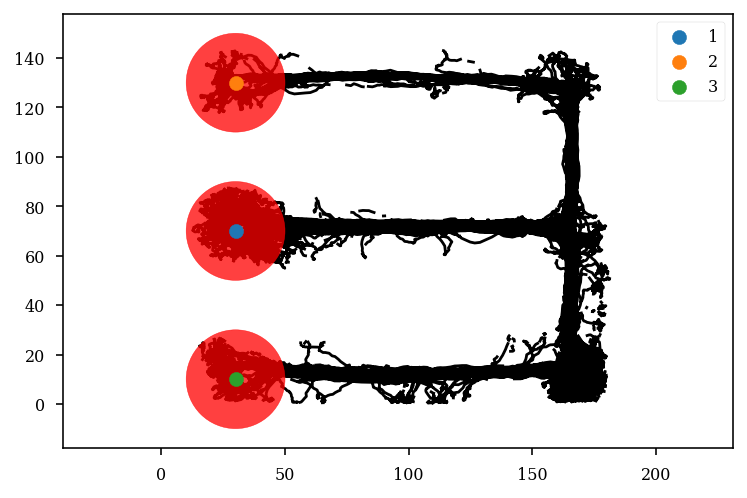

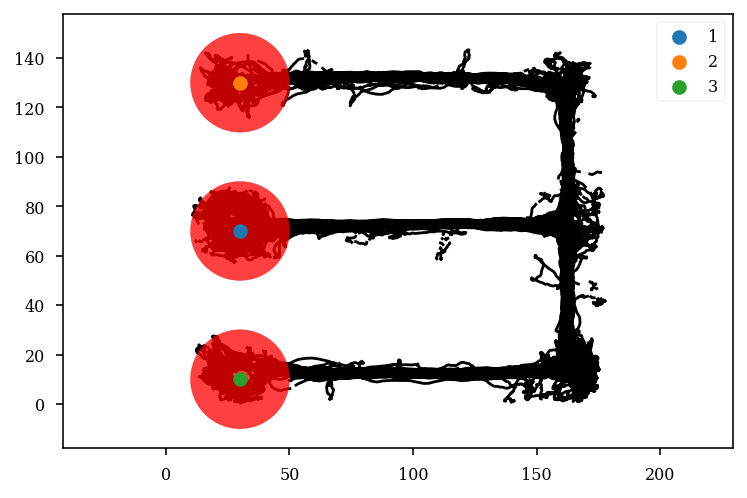

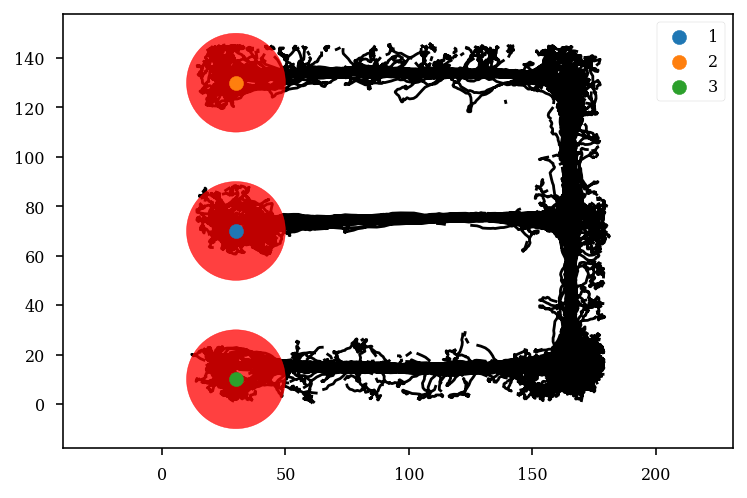

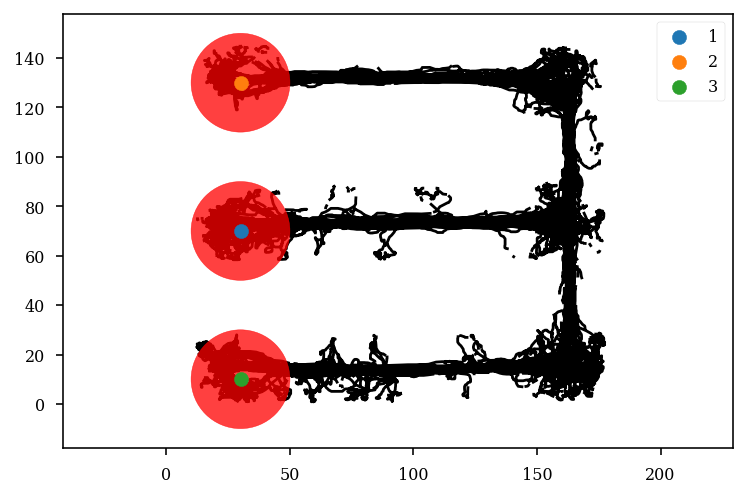

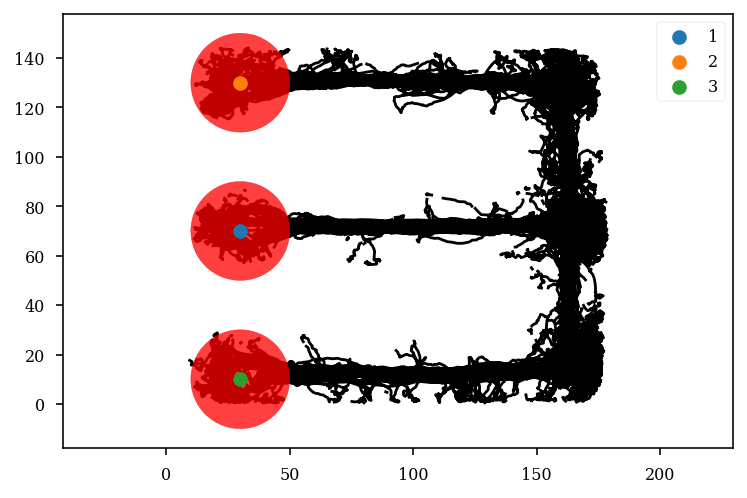

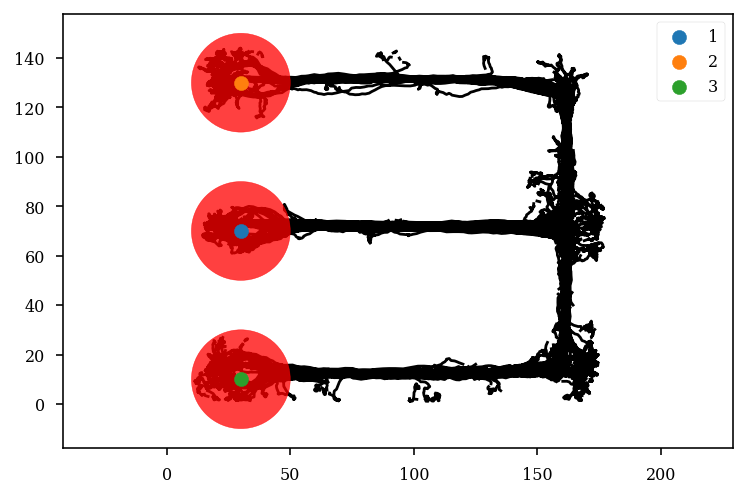

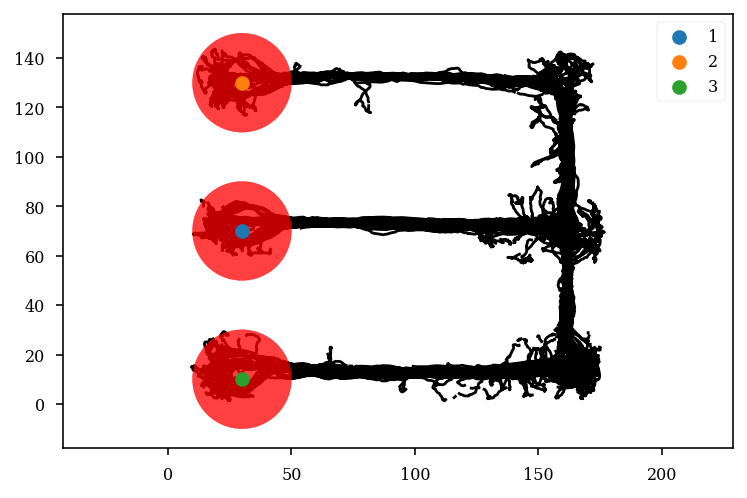

In [66]:
for basepath in basepaths.basepath:
    position_df = loading.load_animal_behavior(basepath)
    beh_epoch = loading.load_epoch(basepath)
    if (beh_epoch.environment.str.contains('wmaze') == False).all():
        continue
    idx = position_df.time.between(beh_epoch.query("environment == 'wmaze'").startTime.values[0],beh_epoch.query("environment == 'wmaze'").stopTime.values[0])
    position_df = position_df[idx]

    center_well = [30,70]
    well_locations = np.array([
        center_well,
        [
            center_well[0],
            center_well[1]+60,
        ],
        [
            center_well[0],
            center_well[1]-60,
        ]
    ])
    plt.plot(position_df.x,position_df.y,color="k")
    plt.axis("equal")
    for xy_i, xy in enumerate(well_locations):
        plt.scatter(xy[0], xy[1], s=50,label = xy_i+1,zorder=100)
        circle1 = plt.Circle((xy[0], xy[1]), 20, color='r',alpha=.75,zorder=80)
        plt.gca().add_patch(circle1)
    plt.legend()
    plt.show()

In [41]:
basepath = r"Z:/Data/HMC2\day10"
position_df = loading.load_animal_behavior(basepath)
beh_epoch = loading.load_epoch(basepath)
beh_epoch

,name,startTime,stopTime,environment,behavioralParadigm,notes
0,presleep_221019_094251,0.0000,7716.37115,sleep,NaN,NaN
1,wmaze_221019_115238,7716.3712,10593.00000,wmaze,delayed,20-sec delay
2,postsleep_221019_124547,10592.8576,18933.93275,sleep,NaN,NaN
3,tmaze_3__221019_152947,18933.9328,20918.39995,tmaze,NaN,NaN
4,postsleep_221019_160408,20918.4000,28413.13915,sleep,NaN,NaN


In [42]:
idx = position_df.time.between(beh_epoch.query("environment == 'wmaze'").startTime.values[0],beh_epoch.query("environment == 'wmaze'").stopTime.values[0])
position_df = position_df[idx]



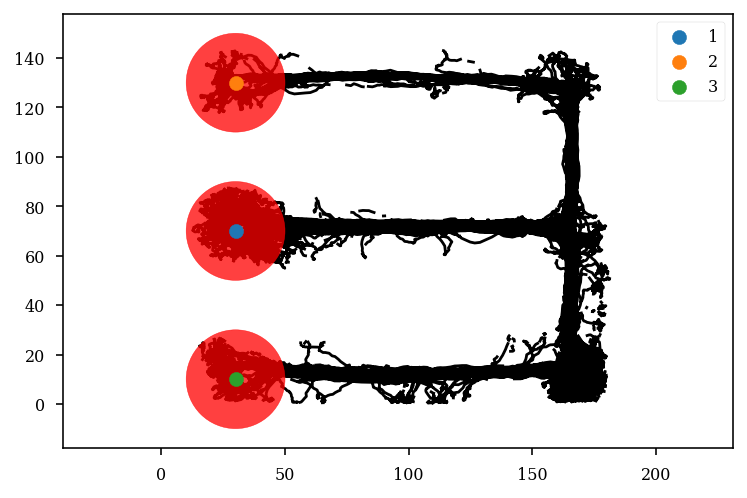

In [49]:
center_well = [30,70]
well_locations = np.array([
    center_well,
    [
        center_well[0],
        center_well[1]+60,
    ],
    [
        center_well[0],
        center_well[1]-60,
    ]
])
plt.plot(position_df.x,position_df.y,color="k")
plt.axis("equal")
for xy_i, xy in enumerate(well_locations):
    plt.scatter(xy[0], xy[1], s=50,label = xy_i+1,zorder=100)
    circle1 = plt.Circle((xy[0], xy[1]), 20, color='r',alpha=.75,zorder=80)
    plt.gca().add_patch(circle1)
plt.legend()

In [76]:
temp_df = position_df[~np.isnan(position_df.x)]

segments_df, _ = well_traversal_classification.segment_path(
    temp_df["timestamps"].values,
    temp_df[["x", "y"]].values,
    well_locations,
    max_distance_from_well=20,
)
x_range = position_df.x.max() - position_df.x.min()
segments_df = well_traversal_classification.score_inbound_outbound(
    segments_df, min_distance_traveled=x_range
)

display(segments_df.query("task == 'Outbound'").is_correct.value_counts().reset_index())
display(segments_df.query("task == 'Inbound'").is_correct.value_counts().reset_index())


,index,is_correct
0,False,47
1,True,27


,index,is_correct
0,True,32
1,False,6


In [78]:
segments_df.query("task == 'Outbound'")

,start_time,end_time,duration,from_well,to_well,distance_traveled,task,is_correct,turn
segment,,,,,,,,,
9,9089.47635,9132.12650,42.65015,Center,Center,741.243389,Outbound,False,
13,9149.37660,9196.10180,46.72520,Center,Center,1104.321393,Outbound,False,
15,9198.90180,9218.50190,19.60010,Center,Left,480.092322,Outbound,True,Right
19,9233.00195,9261.85210,28.85015,Center,Center,605.109208,Outbound,False,Left
24,9272.72715,9304.45225,31.72510,Center,Center,618.196291,Outbound,False,Left
...,...,...,...,...,...,...,...,...,...
231,19975.41910,19987.44715,12.02805,Center,Right,376.843718,Outbound,True,Left
233,20020.53050,20038.13495,17.60445,Center,Left,414.322459,Outbound,True,Right
235,20066.39210,20070.49310,4.10100,Center,Right,271.063215,Outbound,True,Left


In [64]:
np.mean(segments_df.query("task == 'Outbound'").is_correct), np.mean(segments_df.query("task == 'Inbound'").is_correct),

(0.6470588235294118, 0.6818181818181818)